In [6]:
from os import PathLike

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from rich import inspect
from utils import *

mpl.rcParams["figure.dpi"] = 300

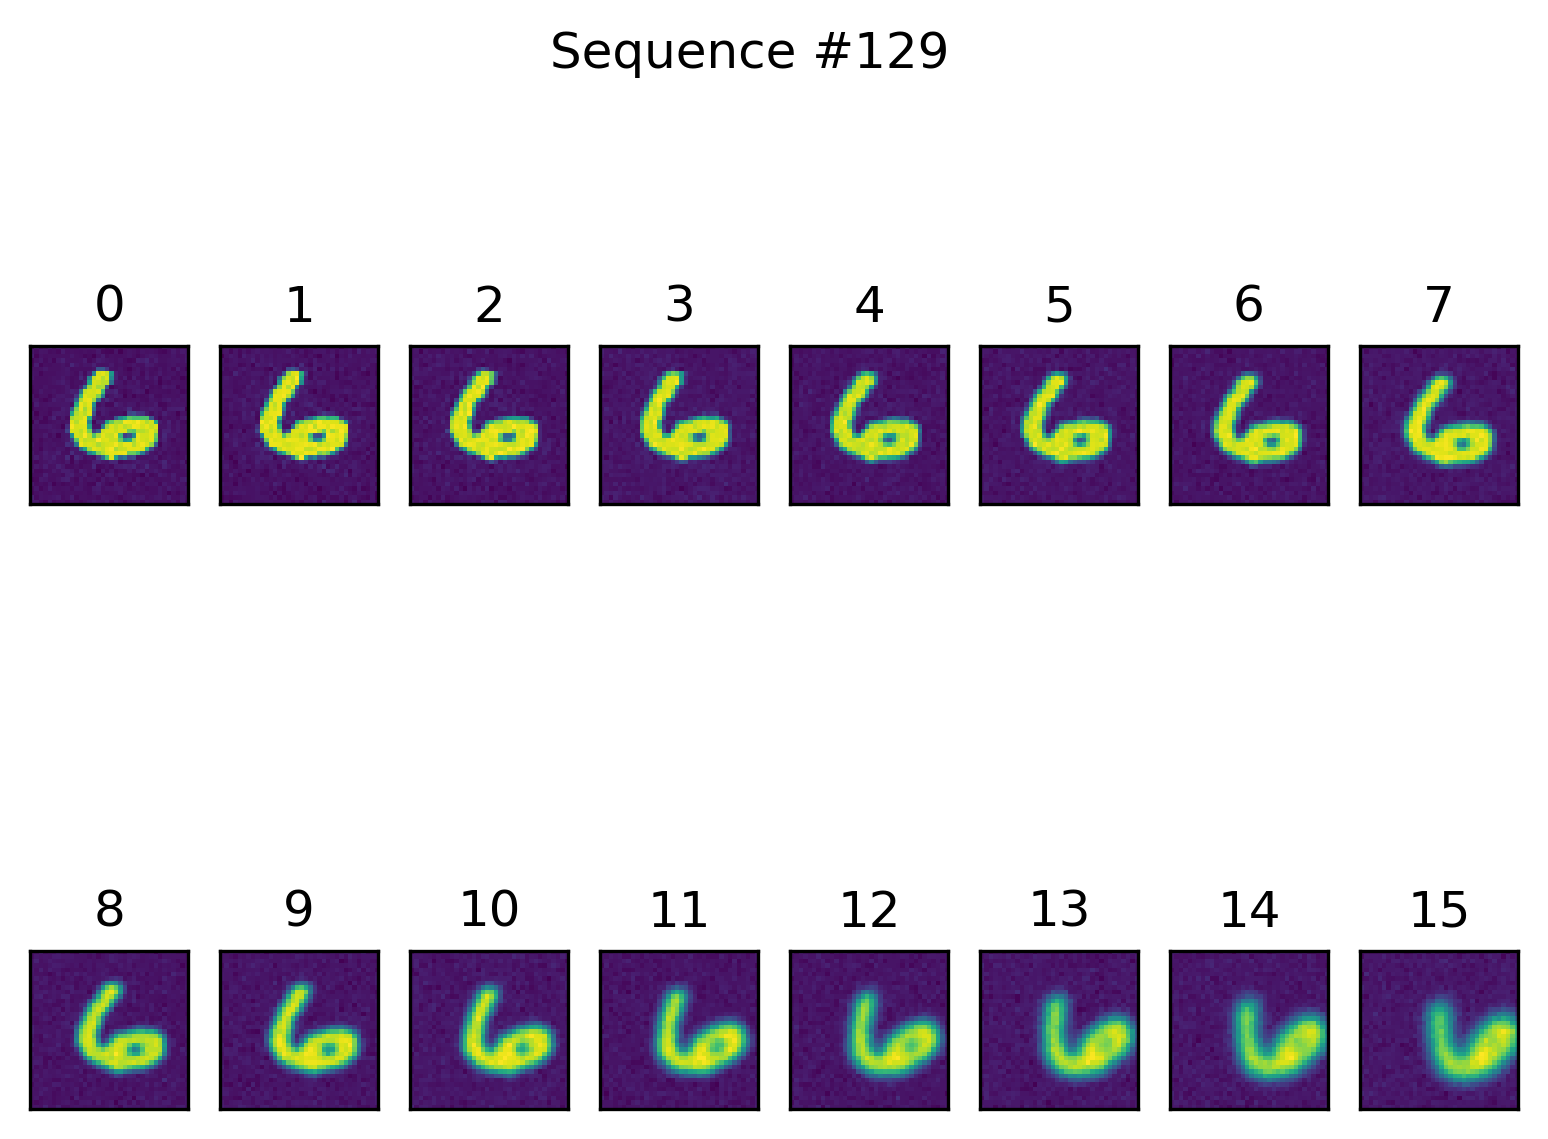

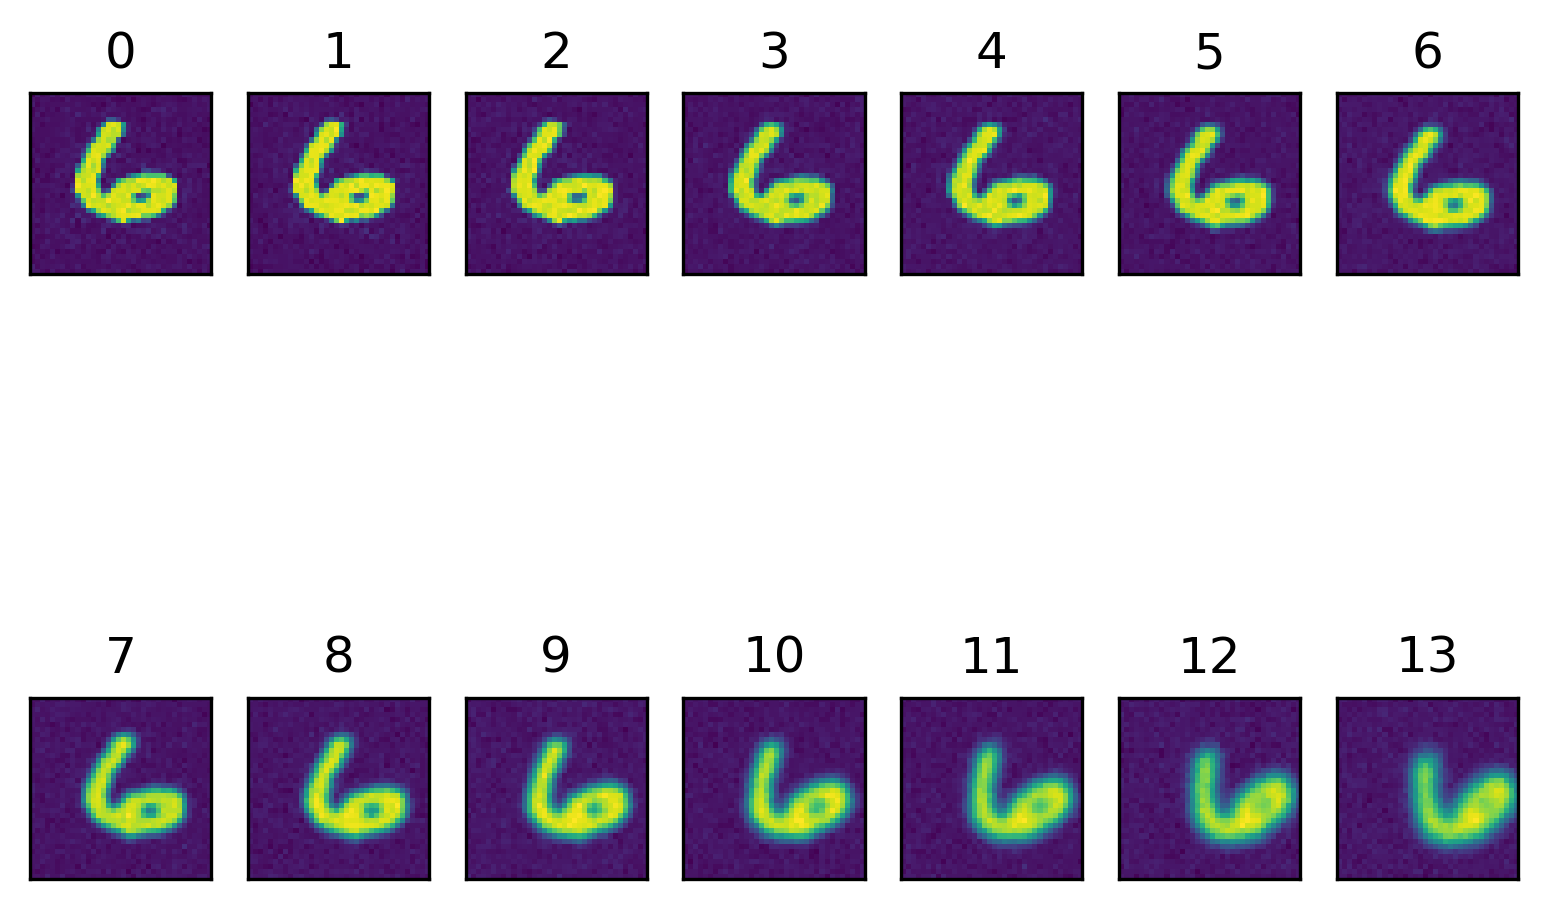

In [10]:
def plot_full_sequence(sequence_id: int, train, test=None):
    fig, axes = plt.subplots(2, 8)
    fig.suptitle(f"Sequence #{sequence_id}")
    axes = axes.flatten()

    train_images = train[sequence_id]
    train_img_iter = iter(train_images)

    if test:
        test_images = test[sequence_id]
        test_images_iter = iter(test_images)
    for i, ax in enumerate(axes):
        ax.title.set_text(i)
        ax.set_xticks([])
        ax.set_yticks([])

        if i == 3 or i == 15:
            if test:
                img = next(test_images_iter)
            else:
                img = np.zeros((IMAGE_SHAPE))
        else:
            img = next(train_img_iter)

        ax.imshow(img)


def plot_train_sequence(n, data):
    fig, axs = plt.subplots(2, 7)
    axs = axs.flatten()
    for i, (img, ax) in enumerate(zip(data[n], axs)):
        ax.imshow(img)
        ax.title.set_text(i)
        ax.set_xticks([])
        ax.set_yticks([])


n = np.random.randint(0, 400)
plot_full_sequence(n, n6_train, n6_test)
plot_train_sequence(n, n6_train)
plt.show()

In [ ]:
def get_pairs(sequence_id: int, data):
    pair_idxs = [
        (0, 1),
        (1, 2),
        (4, 5),
        (6, 7),
        (7, 8),
        (8, 9),
        (9, 10),
        (10, 11),
        (11, 12),
        (12, 13),
    ]

    seq = data[sequence_id]

    return np.array([(seq[i], seq[j]) for i, j in pair_idxs])


differences = np.array(
    [[j - i for i, j in get_pairs(idx, n6_train)] for idx, seq in enumerate(n6_train)]
)

differences = differences.reshape(4000, 1296)

(4000, 1296)

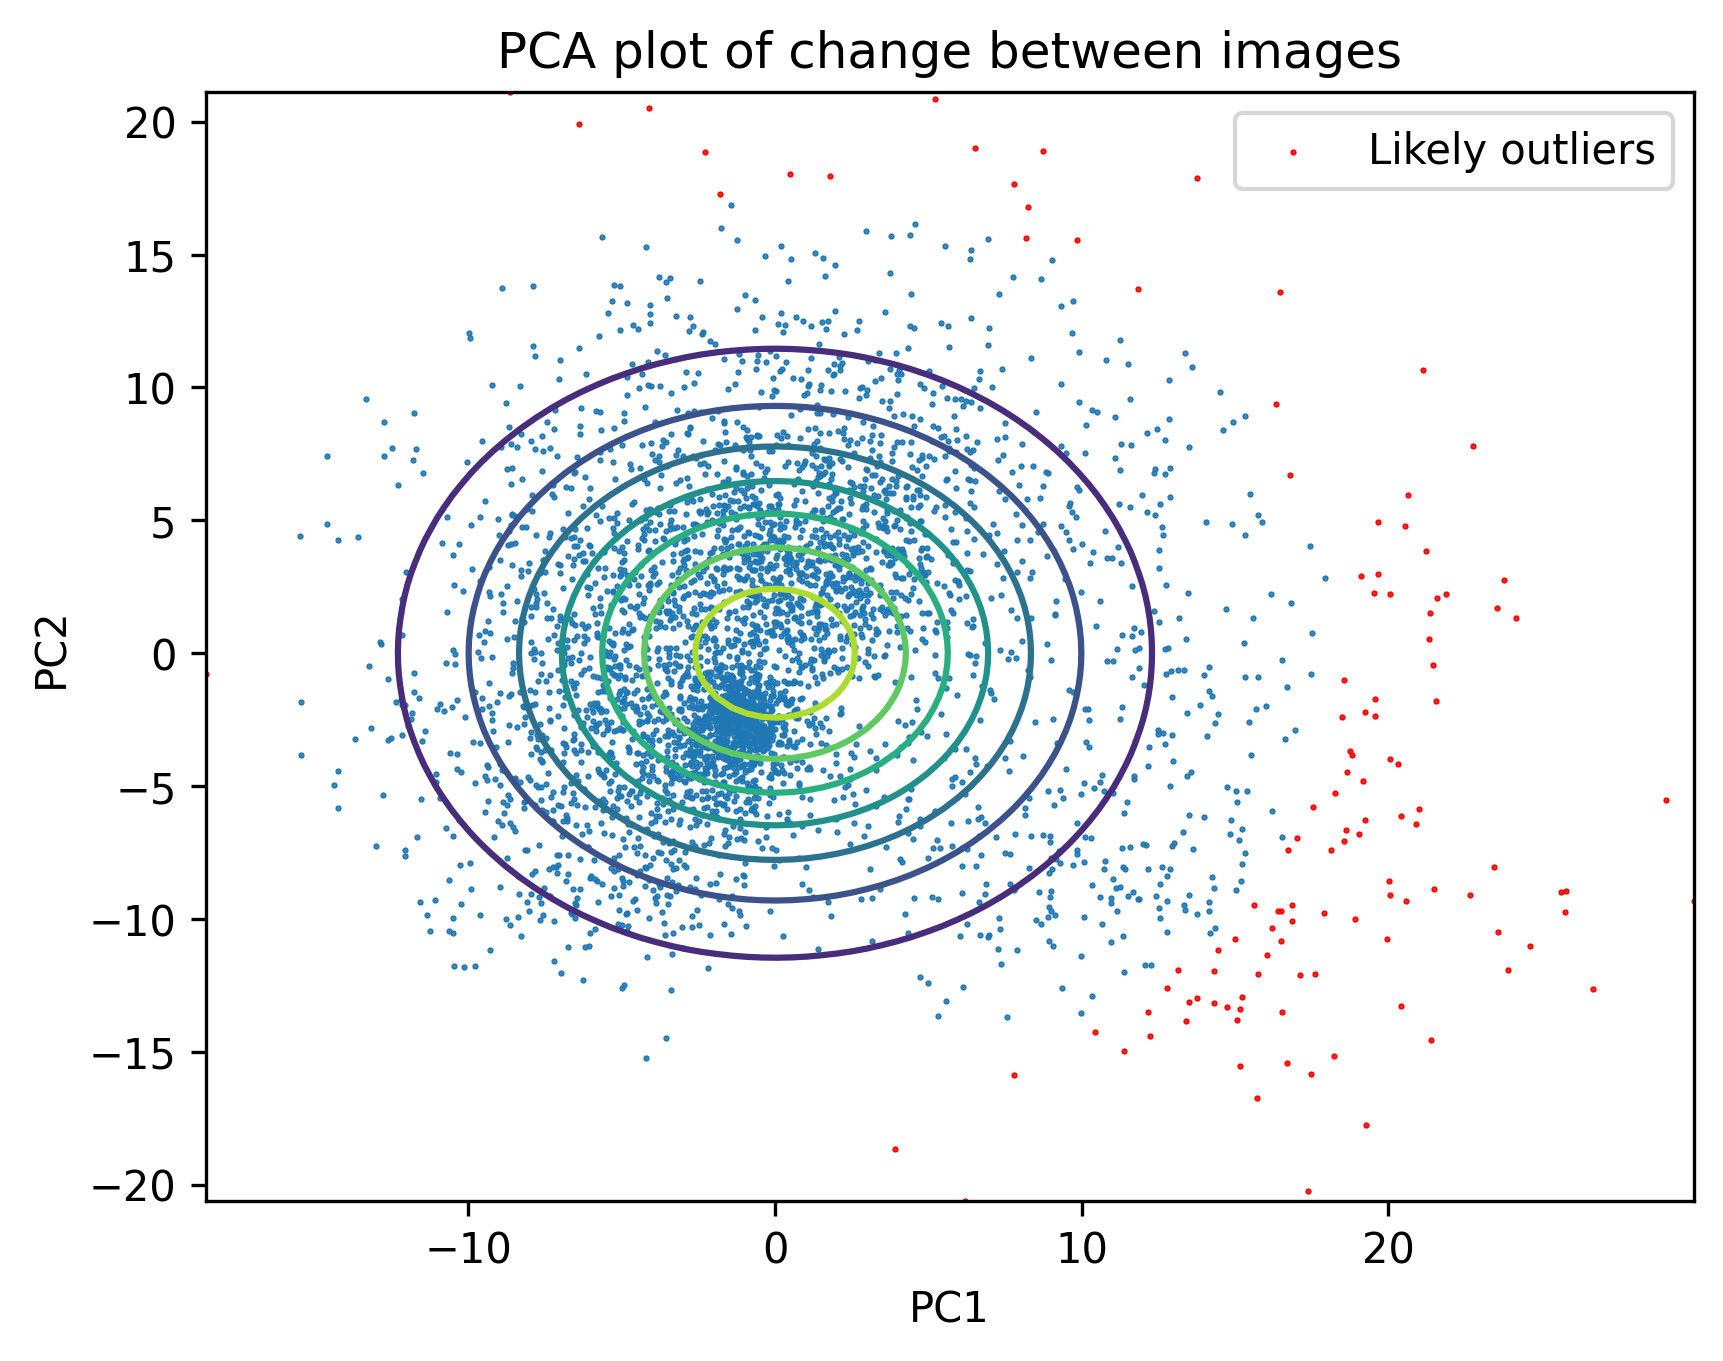

In [27]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

x_scaled = StandardScaler().fit_transform(differences)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_scaled)
X = pca_features[:, 0]
Y = pca_features[:, 1]
d = np.vstack((X, Y)).T
mu = np.mean(d, axis=0)
cov = np.cov(d, rowvar=False)


x = np.linspace(X.min(), X.max(), 100)
y = np.linspace(Y.min(), Y.max(), 100)
X_grid, Y_grid = np.meshgrid(x, y)
pos = np.dstack((X_grid, Y_grid))

# Compute the probability density of the grid points
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)


def is_within_dist(points, mu, cov, n=3):
    diff = points - mu
    inv_cov = np.linalg.inv(cov)

    # Compute Mahalanobis distance for all points
    mahalanobis_distances = np.sqrt(
        np.sum(diff @ inv_cov * diff, axis=1)
    )  # Shape: (num_points,)

    # Check if distances are within n standard deviations
    return mahalanobis_distances <= n


a = pca_features[is_within_dist(pca_features, mu, cov)]
b = pca_features[~is_within_dist(pca_features, mu, cov)]

plt.scatter(a[:, 0], a[:, 1], s=0.25)
plt.scatter(b[:, 0], b[:, 1], c="red", s=0.25, label="Likely outliers")


plt.contour(X_grid, Y_grid, Z)
plt.title("PCA plot of change between images")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

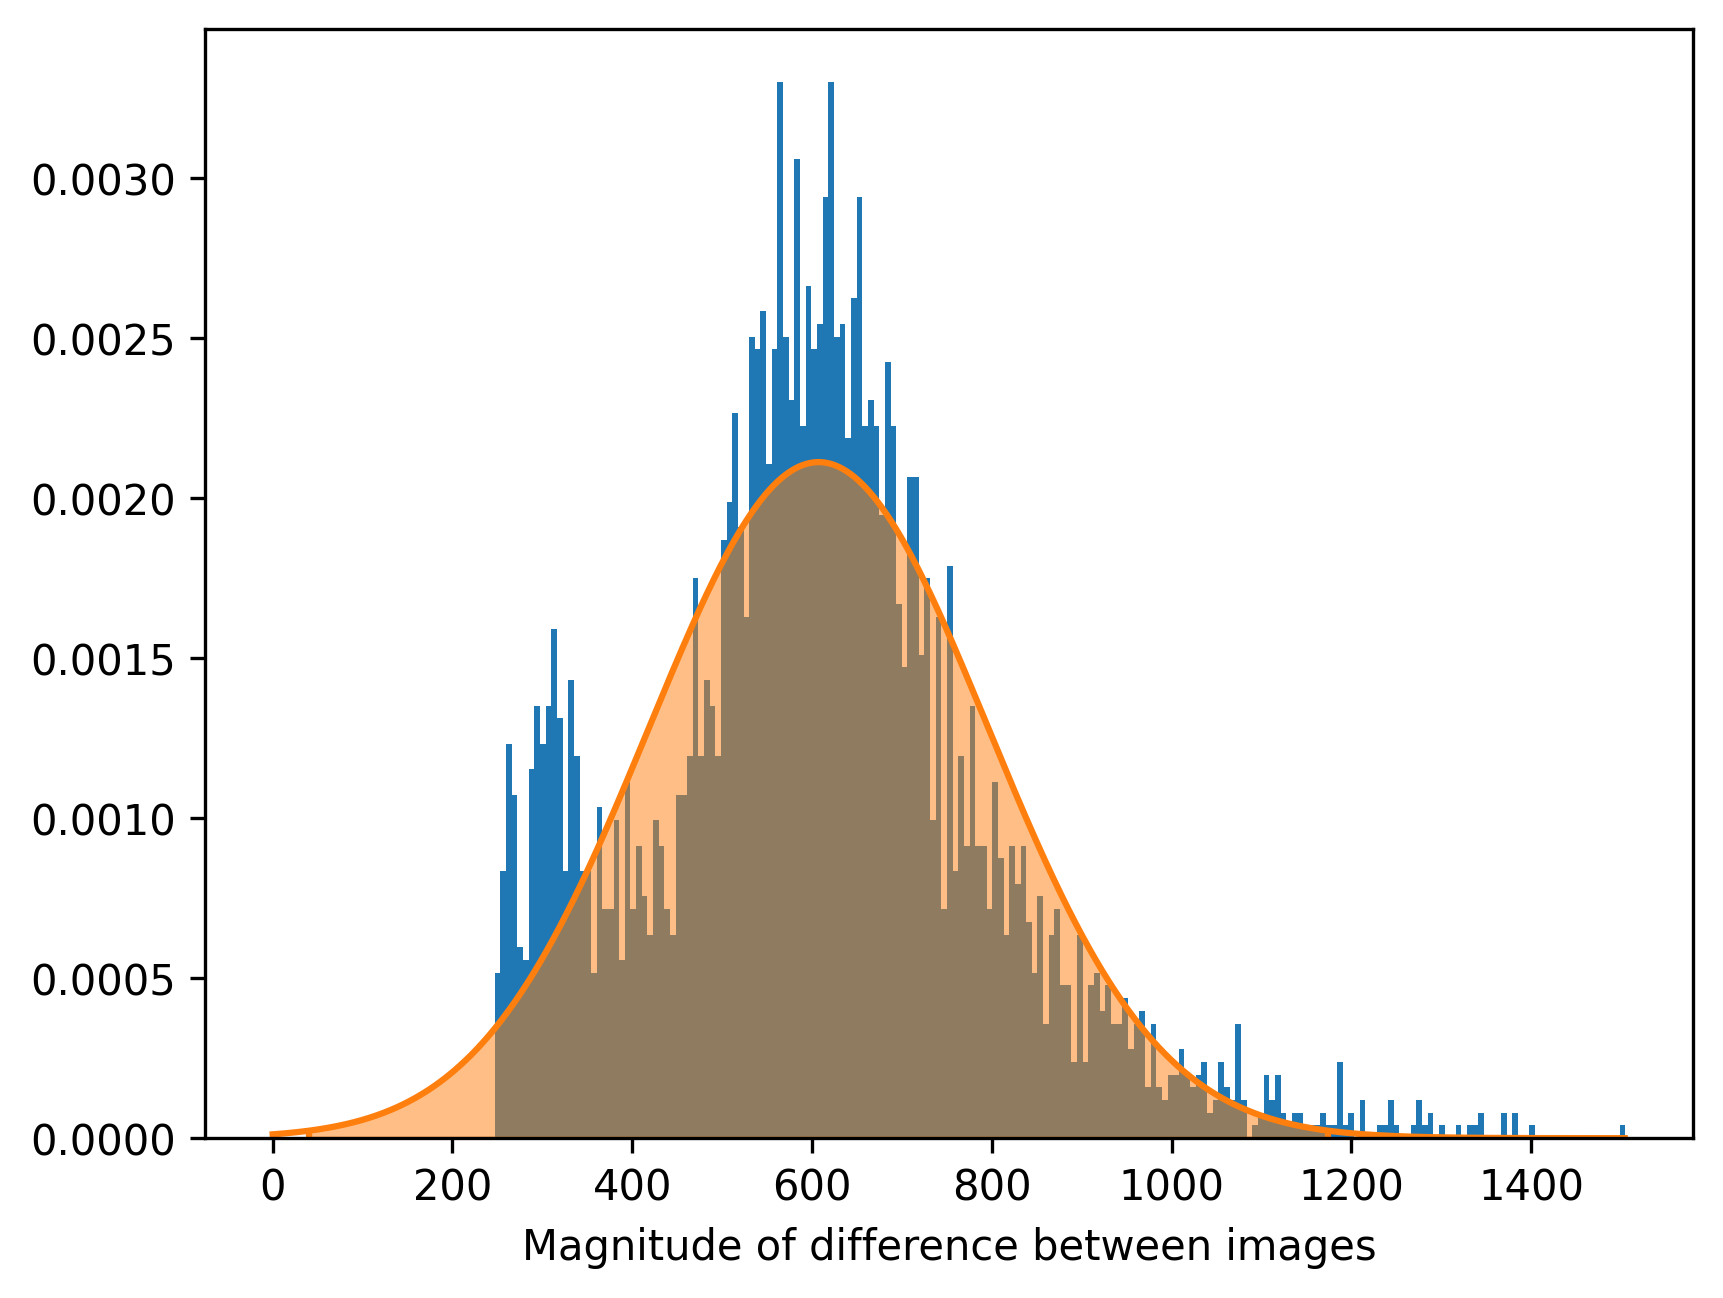

In [ ]:
from scipy.stats import norm

diff_mag = np.linalg.norm(differences, axis=1)
max_change = np.max(diff_mag)
mu, std = norm.fit(diff_mag)
xs = np.arange(0, max_change)
extent = 3
lb = (-extent * std) + mu
ub = (extent * std) + mu
likely_non_outliers = np.arange(lb, ub)
xs_2 = xs[(xs > lb) & (xs < ub)]
p2 = norm.pdf(xs_2, mu, std)

p = norm.pdf(xs, mu, std)
plt.hist(diff_mag, density=True, color="C0", bins=200)
plt.plot(xs, p, color="C1")
plt.fill_between(xs_2, p2, alpha=0.5, color="C1")
plt.vlines(lb, 0, norm.pdf(lb, mu, std), color="C1")
plt.vlines(ub, 0, norm.pdf(ub, mu, std), color="C1")
plt.xlabel("Magnitude of difference between images")
plt.show()

In [ ]:
possible_outliers = []

for seq_id, seq in enumerate(n6_train):
    for i in range(1, 15):
        if i in [3, 14]:
            continue
        diff = seq[i] - seq[i - 1]
        if not (lb < np.linalg.norm(diff) < ub):
            possible_outliers.append((seq_id, i, i - 1))

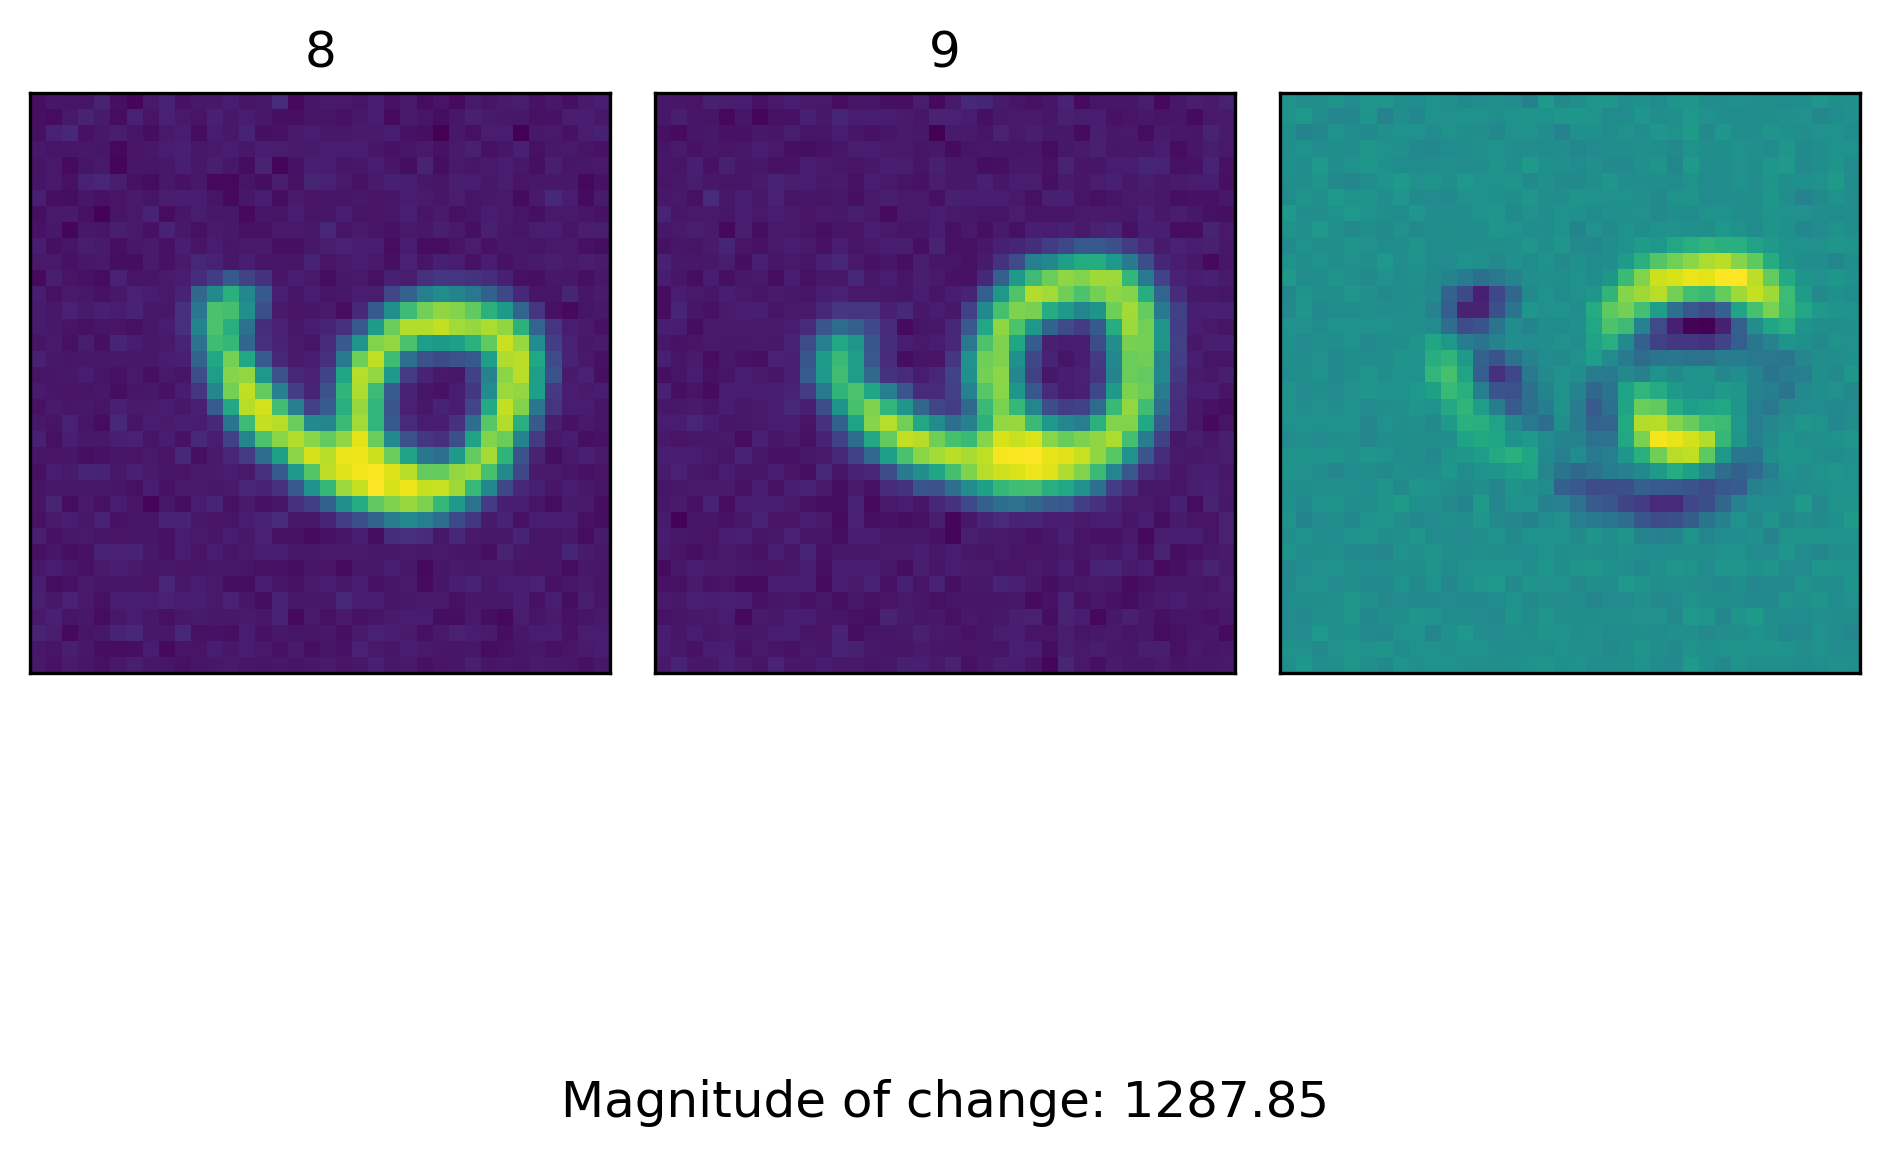

In [ ]:
n_outliers = len(possible_outliers)


def show_potential_outlier(id, img1_id, img2_id):
    seq = n6_train[id]
    img1 = seq[img1_id]
    img2 = seq[img2_id]
    fig, axs = plt.subplots(1, 3)
    fig.text(
        0.5,
        0,
        f"Magnitude of change: {np.linalg.norm(img1 - img2):.2f}",
        ha="center",
        va="center",
        fontsize=12,
    )

    axs[1].imshow(img1)
    axs[1].title.set_text(img1_id)
    axs[0].imshow(img2)
    axs[0].title.set_text(img2_id)
    axs[2].imshow(img1 - img2)
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()


outlier = possible_outliers[np.random.choice(n_outliers)]

show_potential_outlier(*outlier)